<a href="https://colab.research.google.com/github/wrn6494/-8-Week-SQL-Challenge/blob/main/Case_Study_1_Danny's_Diner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **8 Week SQL Challenge : Case Study #1 - Danny's Diner**

Full case study available [here.](https://8weeksqlchallenge.com/case-study-1/)

**Probem Statement/Business Task**

Danny wants to use the data to answer a few simple questions about his customers.

*   customer visiting patterns
*   how much money they’ve spent
*   which menu items are the customer's favourite 

Having this deeper connection with his customers will help him **deliver a better and more personalised experience for his loyal customers**.

He plans on using these insights to help him **decide whether he should expand the existing customer loyalty program** - additionally he needs help to generate some basic datasets so his team can easily inspect the data without needing to use SQL.

Danny has provided you with a **sample of his overall customer data due to privacy issues** - but he hopes that these examples are enough for you to write fully functioning SQL queries to help him answer his questions!

There are 3 key datasets available for this case study:

*   sales
*   menu
*   members

**Schema (PostgreSQL v13)**

    CREATE SCHEMA dannys_diner;
    SET search_path = dannys_diner;
    
    CREATE TABLE sales (
      "customer_id" VARCHAR(1),
      "order_date" DATE,
      "product_id" INTEGER
    );
    
    INSERT INTO sales
      ("customer_id", "order_date", "product_id")
    VALUES
      ('A', '2021-01-01', '1'),
      ('A', '2021-01-01', '2'),
      ('A', '2021-01-07', '2'),
      ('A', '2021-01-10', '3'),
      ('A', '2021-01-11', '3'),
      ('A', '2021-01-11', '3'),
      ('B', '2021-01-01', '2'),
      ('B', '2021-01-02', '2'),
      ('B', '2021-01-04', '1'),
      ('B', '2021-01-11', '1'),
      ('B', '2021-01-16', '3'),
      ('B', '2021-02-01', '3'),
      ('C', '2021-01-01', '3'),
      ('C', '2021-01-01', '3'),
      ('C', '2021-01-07', '3');
     
    
    CREATE TABLE menu (
      "product_id" INTEGER,
      "product_name" VARCHAR(5),
      "price" INTEGER
    );
    
    INSERT INTO menu
      ("product_id", "product_name", "price")
    VALUES
      ('1', 'sushi', '10'),
      ('2', 'curry', '15'),
      ('3', 'ramen', '12');
      
    
    CREATE TABLE members (
      "customer_id" VARCHAR(1),
      "join_date" DATE
    );
    
    INSERT INTO members
      ("customer_id", "join_date")
    VALUES
      ('A', '2021-01-07'),
      ('B', '2021-01-09');

**Entity Relationship Diagram**

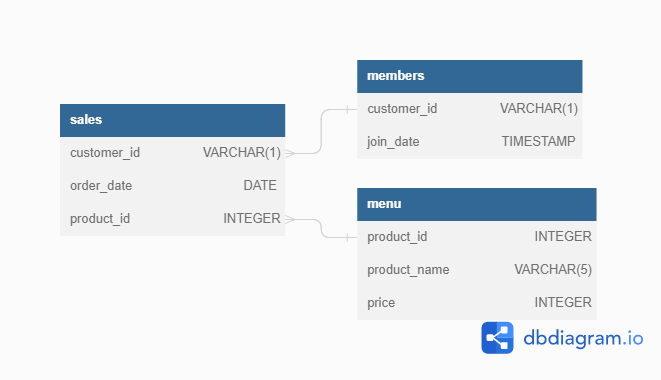

**Case Study Questions**
1. What is the total amount each customer spent at the restaurant?
2. How many days has each customer visited the restaurant?
3. What was the first item from the menu purchased by each customer?
4. What is the most purchased item on the menu and how many times was it purchased by all customers?
5. Which item was the most popular for each customer?
6. Which item was purchased first by the customer after they became a member?
7. Which item was purchased just before the customer became a member?
8. What is the total items and amount spent for each member before they became a member?
9.  If each $1 spent equates to 10 points and sushi has a 2x points multiplier - how many points would each customer have?
10. In the first week after a customer joins the program (including their join date) they earn 2x points on all items, not just sushi - how many points do customer A and B have at the end of January?

**Solution**

PostgreSQL v13 was used.
Functions used are:

*   Aggregate functions — SUM, COUNT
*   Joins — Inner join, full join
*   Temp tables (CTE)
*   Windows function
*   Subqueries

**1. What is the total amount each customer spent at the restaurant?**

    SELECT
      customer_id,
      SUM(price) AS total_sales
    FROM dannys_diner.sales s 
    JOIN dannys_diner.menu m
      ON s.product_id=m.product_id
    GROUP BY customer_id
    ORDER BY customer_id;

| customer_id | total_sales |
| ----------- | ----------- |
| A           | 76          |
| B           | 74          |
| C           | 36          |

**Answer:**

*   Customer A spent 76 dollars.
*   Customer B spent 74 dollars.
*   Customer C spent 36 dollars.

**2. How many days has each customer visited the restaurant?**

    SELECT
      customer_id,
      COUNT(DISTINCT order_date) AS no_of_days_visited
    FROM dannys_diner.sales
    GROUP BY customer_id
    ORDER BY customer_id;

| customer_id | no_of_days_visited |
| ----------- | ------------------ |
| A           | 4                  |
| B           | 6                  |
| C           | 2                  |


**Answer:**

*   Customer A visited 4 times.
*   Customer B visited 6 times.
*   Customer C visited 2 times.

**3. What was the first item from the menu purchased by each customer?**

    SELECT 
      DISTINCT customer_id,
      product_name
    FROM 
      (
      SELECT *,
      RANK() OVER (PARTITION BY customer_id ORDER BY order_date) AS rank
      FROM dannys_diner.sales s 
    	JOIN  dannys_diner.menu m
    	  ON s.product_id=m.product_id
      ) AS a
    WHERE rank = 1
    ORDER BY customer_id;

| customer_id | product_name |
| ----------- | ------------ |
| A           | curry        |
| A           | sushi        |
| B           | curry        |
| C           | ramen        |

**Answer:**

*   Customer A ordered curry and sushi first.
*   Customer B ordered curry.
*   Customer C ordered ramen.

**4. What is the most purchased item on the menu and how many times was it purchased by all customers?**

    SELECT
      product_name,
      COUNT(s.product_id) AS total_sales
    FROM dannys_diner.sales s 
    JOIN  dannys_diner.menu m
      ON s.product_id=m.product_id
    GROUP BY product_name
    ORDER BY total_sales DESC
    LIMIT 1;

| product_name | total_sales |
| ------------ | ----------- |
| ramen        | 8           |

**Answer:**

*   Most purchased product on the menu is ramen.

**5. Which item was the most popular for each customer?**

    SELECT 
      customer_id,
      product_name, 
      total_orders
    FROM
      (
      SELECT customer_id,
        product_name,
        COUNT(s.product_id) AS total_orders,
        RANK() OVER (PARTITION BY customer_id ORDER BY COUNT(s.product_id) DESC) AS rank
      FROM dannys_diner.sales s 
    	JOIN  dannys_diner.menu m
    	  ON s.product_id=m.product_id
      GROUP BY customer_id,product_name
      ORDER BY customer_id
      ) AS a
    WHERE rank=1
    GROUP BY customer_id,product_name,total_orders
    ORDER BY customer_id,product_name;

| customer_id | product_name | total_orders |
| ----------- | ------------ | ------------ |
| A           | ramen        | 3            |
| B           | curry        | 2            |
| B           | ramen        | 2            |
| B           | sushi        | 2            |
| C           | ramen        | 3            |

**Answer:**

*   Customer A and C like ramen the most.
*   Customer B likes the whole menu, he/she ordered curry,ramen and sushi equally.


**6. Which item was purchased first by the customer after they became a member?**

    SELECT 
      DISTINCT a.customer_id,
      order_date,
      product_name
    FROM 
      (
      SELECT s.customer_id,
        s.order_date,
        s.product_id,
        RANK() OVER (PARTITION BY s.customer_id ORDER BY s.order_date) AS rank
      FROM dannys_diner.sales s 
      JOIN dannys_diner.members mm
        ON s.customer_id=mm.customer_id
      WHERE s.order_date>=mm.join_date
      ) AS a
    JOIN  dannys_diner.menu m
      ON a.product_id=m.product_id
    WHERE rank = 1
    ORDER BY a.customer_id;

| customer_id | order_date               | product_name |
| ----------- | ------------------------ | ------------ |
| A           | 2021-01-07T00:00:00.000Z | curry        |
| B           | 2021-01-11T00:00:00.000Z | sushi        |

**Answer**
*   Customer A ordered curry.
*   Customer B ordered sushi.



**7. Which item was purchased just before the customer became a member?**

    SELECT 
      DISTINCT a.customer_id,
    	order_date,
      product_name
    FROM 
      (
      SELECT s.customer_id,
        order_date,
        product_id,
        RANK() OVER (PARTITION BY s.customer_id ORDER BY order_date DESC) AS rank
      FROM dannys_diner.sales s 
      JOIN dannys_diner.members mm
        ON s.customer_id=mm.customer_id
      WHERE s.order_date<mm.join_date
      ) AS a
    JOIN  dannys_diner.menu m
    	ON a.product_id=m.product_id
    WHERE rank = 1
    ORDER BY a.customer_id;

| customer_id | order_date               | product_name |
| ----------- | ------------------------ | ------------ |
| A           | 2021-01-01T00:00:00.000Z | curry        |
| A           | 2021-01-01T00:00:00.000Z | sushi        |
| B           | 2021-01-04T00:00:00.000Z | sushi        |

**Answer**
*   Customer A ordered curry and sushi before becoming a member.
*   Customer B ordered sushi.


**8. What is the total items and amount spent for each member before they became a member?**

    SELECT 
      DISTINCT s.customer_id,
      COUNT(DISTINCT product_name) AS total_items,
      SUM(price) AS amount_spent
    FROM dannys_diner.sales s 
    JOIN dannys_diner.members mm
      ON s.customer_id=mm.customer_id
    JOIN  dannys_diner.menu m
    	ON s.product_id=m.product_id
    WHERE order_date<join_date
    GROUP BY s.customer_id
    ORDER BY s.customer_id;

| customer_id | total_items | amount_spent |
| ----------- | ----------- | ------------ |
| A           | 2           | 25           |
| B           | 2           | 40           |

**Answer**
*   Customer A ordered 2 items with total amount of 25 dollars.
*   Customer B ordered 2 items with total amount of 40 dollars.


**9.  If each $1 spent equates to 10 points and sushi has a 2x points multiplier - how many points would each customer have?**

    SELECT 
      DISTINCT s.customer_id,
    	SUM(
        CASE WHEN product_name= 'sushi' 
    	  THEN price*20 
    	  ELSE price*10
    	  END) AS points_sum
    FROM dannys_diner.sales s 
    JOIN  dannys_diner.menu m
    	ON s.product_id=m.product_id
    GROUP BY s.customer_id
    ORDER BY s.customer_id;

| customer_id | points_sum |
| ----------- | ---------- |
| A           | 860        |
| B           | 940        |
| C           | 360        |

**Answer**

*   Customer A would have a total of 860 points.
*   Customer B would have a total of 940 points.
*   Customer C would have a total of 360 points.



**10. In the first week after a customer joins the program (including their join date) they earn 2x points on all items, not just sushi - how many points do customer A and B have at the end of January?**

    WITH a AS
      (
      SELECT DISTINCT customer_id, 
        (join_date +INTERVAL '6 days') AS endpromotions_date
      FROM dannys_diner.members mm
      )
    
    SELECT
      s.customer_id,
      SUM(
        CASE WHEN (order_date BETWEEN join_date AND endpromotions_date)
        THEN price*20
        WHEN product_name= 'sushi' 
        THEN price*20
        ELSE price*10
        END) AS points_sum
    FROM dannys_diner.menu m
    JOIN dannys_diner.sales s
      ON m.product_id=s.product_id
    JOIN dannys_diner.members mm
      ON s.customer_id=mm.customer_id
    JOIN a 
      ON a.customer_id=mm.customer_id
    WHERE order_date<'2021-02-01'
    GROUP BY s.customer_id
    ORDER BY s.customer_id;

| customer_id | points_sum |
| ----------- | ---------- |
| A           | 1370       |
| B           | 820        |


**Answer**

*   Customer A would have a total of 1370 points.
*   Customer B would have a total of 820 points.

**Bonus Question: Recreate the table with: customer_id, order_date, product_name, price, member (Y/N)**

    SELECT
      s.customer_id,
      order_date,
      product_name,
      price,
      (CASE WHEN order_date >= join_date
      THEN 'Y'
      ELSE 'N'
      END) AS member
    FROM dannys_diner.menu m
    FULL JOIN dannys_diner.sales s
      ON m.product_id=s.product_id
    FULL JOIN dannys_diner.members mm
      ON s.customer_id=mm.customer_id
    ORDER BY s.customer_id, order_date,product_name;

| customer_id | order_date               | product_name | price | member |
| ----------- | ------------------------ | ------------ | ----- | ------ |
| A           | 2021-01-01T00:00:00.000Z | curry        | 15    | N      |
| A           | 2021-01-01T00:00:00.000Z | sushi        | 10    | N      |
| A           | 2021-01-07T00:00:00.000Z | curry        | 15    | Y      |
| A           | 2021-01-10T00:00:00.000Z | ramen        | 12    | Y      |
| A           | 2021-01-11T00:00:00.000Z | ramen        | 12    | Y      |
| A           | 2021-01-11T00:00:00.000Z | ramen        | 12    | Y      |
| B           | 2021-01-01T00:00:00.000Z | curry        | 15    | N      |
| B           | 2021-01-02T00:00:00.000Z | curry        | 15    | N      |
| B           | 2021-01-04T00:00:00.000Z | sushi        | 10    | N      |
| B           | 2021-01-11T00:00:00.000Z | sushi        | 10    | Y      |
| B           | 2021-01-16T00:00:00.000Z | ramen        | 12    | Y      |
| B           | 2021-02-01T00:00:00.000Z | ramen        | 12    | Y      |
| C           | 2021-01-01T00:00:00.000Z | ramen        | 12    | N      |
| C           | 2021-01-01T00:00:00.000Z | ramen        | 12    | N      |
| C           | 2021-01-07T00:00:00.000Z | ramen        | 12    | N      |

**Bonus Question: Ranking of customer products**

    WITH a AS
      (
      SELECT s.customer_id,
        order_date,
        product_name,
        price,
        (CASE WHEN order_date >= join_date
        THEN 'Y'
        ELSE 'N'
        END) AS member
      FROM dannys_diner.menu m
      FULL JOIN dannys_diner.sales s
        ON m.product_id=s.product_id
      FULL JOIN dannys_diner.members mm
        ON s.customer_id=mm.customer_id
      ORDER BY s.customer_id, order_date,product_name
      )
    
    SELECT *, 
      (CASE WHEN member='N' 
      THEN null 
      ELSE RANK() OVER (PARTITION BY a.customer_id,member ORDER BY order_date)
      END) AS ranking
    FROM  a;

| customer_id | order_date               | product_name | price | member | ranking |
| ----------- | ------------------------ | ------------ | ----- | ------ | ------- |
| A           | 2021-01-01T00:00:00.000Z | curry        | 15    | N      |         |
| A           | 2021-01-01T00:00:00.000Z | sushi        | 10    | N      |         |
| A           | 2021-01-07T00:00:00.000Z | curry        | 15    | Y      | 1       |
| A           | 2021-01-10T00:00:00.000Z | ramen        | 12    | Y      | 2       |
| A           | 2021-01-11T00:00:00.000Z | ramen        | 12    | Y      | 3       |
| A           | 2021-01-11T00:00:00.000Z | ramen        | 12    | Y      | 3       |
| B           | 2021-01-01T00:00:00.000Z | curry        | 15    | N      |         |
| B           | 2021-01-02T00:00:00.000Z | curry        | 15    | N      |         |
| B           | 2021-01-04T00:00:00.000Z | sushi        | 10    | N      |         |
| B           | 2021-01-11T00:00:00.000Z | sushi        | 10    | Y      | 1       |
| B           | 2021-01-16T00:00:00.000Z | ramen        | 12    | Y      | 2       |
| B           | 2021-02-01T00:00:00.000Z | ramen        | 12    | Y      | 3       |
| C           | 2021-01-01T00:00:00.000Z | ramen        | 12    | N      |         |
| C           | 2021-01-01T00:00:00.000Z | ramen        | 12    | N      |         |
| C           | 2021-01-07T00:00:00.000Z | ramen        | 12    | N      |         |

**Insights**

1. The last item ordered by Customers A and B before they became members are the same with the first item they bought after becoming a member. They were curry and sushi respectively. Did they like those menu so much that they availed the membership?
2. All the customers love ramen! Customer C have only ordered ramen for his 3 visits. If sushi and curry were the deciding factor for A&B to become a member, maybe Danny can offer a free taste for Customer C to try them. Who knows maybe he'll like it too and decides to become a member.